In [20]:
# univariate lstm example
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Conv1D, Lambda
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.losses import Huber
from keras import metrics
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# define input sequence
raw = pd.read_csv("../Outliers.csv")

# choose a number of time steps
n_steps = 7

# split into samples
X, y = split_sequence(raw.Price, n_steps)

In [3]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
Xreshaped= X.reshape((X.shape[0], X.shape[1], n_features))


In [37]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(Xreshaped, y, epochs=200, verbose=0)
model.save("rollingLSTM")

In [38]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Predict over the rolling window
yhats = []
for window in range(len(X)):
    yhat = model.predict(X[window].reshape((1, n_steps, n_features)))[0][0]
    yhats.append(yhat)

# pad the missing predictions and add to dataframe
yhats[:0] = [np.nan for _ in range(n_steps)] # [np.nan*n_steps]
raw["Predictions"] = yhats

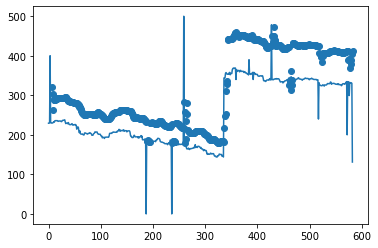

In [6]:
plt.scatter(range(len(yhats)), yhats)
plt.plot(range(len(raw.Price)-1), raw.Price.drop(raw.Price[raw.Price > 1000].index))
#plt.xlim(-1,10)

In [7]:
# calculate residuals and add to original dataframe
raw["Residuals"] = raw.Price - raw.Predictions
# analyse residuals to find outliers
resiStats = raw.Residuals.describe()
IQR = resiStats[6] - resiStats[4]
lowerBound, upperBound = resiStats[4] - 1.5* IQR, resiStats[6] + 1.5* IQR
# flag anomalies in original dataframe
raw["Anomaly"] = (raw.Residuals > upperBound) | (raw.Residuals < lowerBound)

<AxesSubplot:>

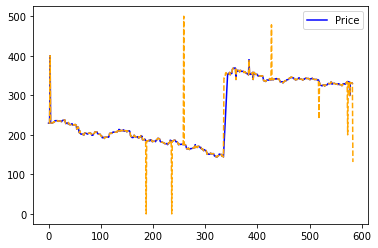

In [8]:
# visualise data
fig, ax = plt.subplots()
raw[["Price"]][raw.Anomaly == False].plot(ax=ax, color="b")
raw.Price.drop(raw[raw.Residuals == raw.Residuals.max()].index).plot(ax=ax, style="--", color="orange")

# visually looks good, how can we prove statistically that we have found all/most anomalies?

Text(0.5, 1.0, 'Raw')

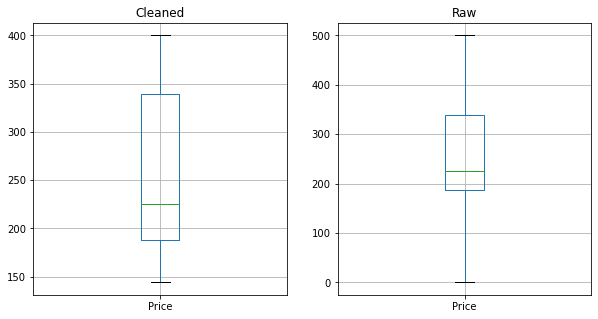

In [9]:
fig, ax = plt.subplots(1,2, figsize=[10,5])
raw[["Price"]][raw.Anomaly == False].boxplot(ax=ax[0])
ax[0].set_title("Cleaned")
raw[["Price"]].drop(raw[raw.Residuals == raw.Residuals.max()].index).boxplot(ax=ax[1])
ax[1].set_title("Raw")

# have we found all anomalies? what is the success criteria?

Text(0.5, 1.0, 'Raw')

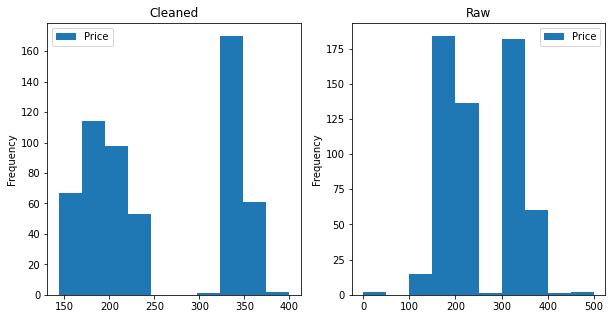

In [10]:
fig, ax = plt.subplots(1,2, figsize=[10,5])
raw[["Price"]][raw.Anomaly == False].plot.hist(ax=ax[0])
ax[0].set_title("Cleaned")
raw[["Price"]].drop(raw[raw.Residuals == raw.Residuals.max()].index).plot.hist(ax=ax[1])
ax[1].set_title("Raw")

Text(0.5, 1.0, 'Raw')

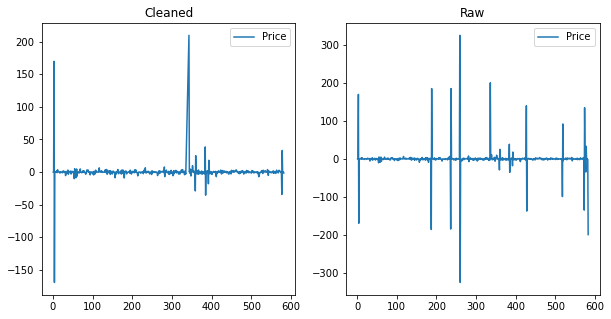

In [11]:
fig, ax = plt.subplots(1,2, figsize=[10,5])
raw[["Price"]][raw.Anomaly == False].diff(1).plot(ax=ax[0])
ax[0].set_title("Cleaned")
raw[["Price"]].drop(raw[raw.Residuals == raw.Residuals.max()].index).diff(1).plot(ax=ax[1])
ax[1].set_title("Raw")

# we can see some false negatives in there 